In [1]:
%matplotlib inline

import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pymc3 as pm

# Chapter 4

## Easy

**4E1** In the model definition below, which line is the likelihood?

```
yi ∼ Normal(μ, σ)
μ ∼ Normal(0, 10)
σ ∼ Uniform(0, 10)
```

The first line is the likelihood

**4E2** In the model definition just above, how many parameters are in the posterior distribution?

It has two parameters to be estimated: μ and σ

**4E3** Using the model definition above, write down the appropriate form of Bayes’ theorem that
includes the proper likelihood and priors.

```
Pr(μ,σ|yi) = ∏i Normal(yi|μ,σ)Normal(μ|0,10)Uniform(σ|0,10) / ∫ ∫ ∏i Normal(yi|μ,σ)Normal(μ|0,10)Uniform(σ|0,10)dμdσ
```

**4E4** In the model de nition below, which line is the linear model? 

```
yi ∼ Normal(μ, σ)
μi = α + βxi
α ∼ Normal(0, 10) 
β ∼ Normal(0, 1)
σ ∼ Uniform(0, 10)
```

The second line

**4E5** In the model de nition just above, how many parameters are in the posterior distribution?

It has two parameters to be estimated: μ and σ

## Medium

**4M1** For the model de nition below, simulate observed heights from the prior (not the posterior)

```
yi ∼ Normal(μ, σ)
μ ∼ Normal(0, 10) 
σ ∼ Uniform(0, 10)
```

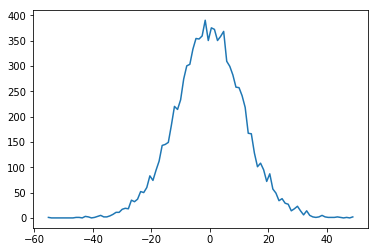

In [2]:
random.seed(100)
sample_mu = np.random.normal(loc=0, scale=10, size=10000)
sample_sigma = np.random.uniform(low=0, high=10, size=10000)
y = np.random.normal(loc=sample_mu, scale=sample_sigma)

y, bin_edges=np.histogram(y, bins=100)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
plt.plot(bin_centers, y)

**4M2** Translate the model just above into a map formula.

In [3]:
basic_model = pm.Model()

with basic_model:

    mu = pm.Normal('mu', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=10)

    # likelihood of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma)

**4M3** Translate the map model formula below into a mathematical model definition.

```
flist <- alist(
    y ~ dnorm( mu , sigma ),
    mu <- a + b*x,
    a ~ dnorm( 0 , 50 ),
    b ~ dunif( 0 , 10 ),
    sigma ~ dunif( 0 , 50 )
```

```
yi ∼ Normal(μ, σ)
μi = α + βxi
α ∼ Normal(0, 50)
β ∼ Unifrom(0, 10)
σ ∼ Uniform(0, 50)
```

**4M4** A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model definition for this regression, using any variable names and priors you choose. Be perepared to defend your choice of priors.

```
yi ∼ Normal(μ, σ)
μi = α + βxi
α ∼ Normal(160, 50)
β ∼ Unifrom(0, 10)
σ ∼ Uniform(0, 10)
```

In this model, yi is the height and xi is the year (first year, second year, etc.). Alpha is the expected height when xi = 0, that is, at the first year. Since I do not know the students' ages, I can not really infer what the expected height for a typical student is during the first year, so I am going to use a very wide prior for alpha. Beta indicates the rate of change in height for every year that passes. Once again, not knowing the age of the students makes it hard to set a prior for this parameter. If the students are young, this rate will be higher. Therefore, and once again, I will use a wide prior (10 centimeters per year seems quite wide to me). Finally, the sigma prior will account for what would be a normal human height range.   

**4M5** Now suppose I tell you that the average height in the first year was 120cm and that every student got taller each year. Does this information lead you to change your choice of priors? How?

That makes change my expected value of alpha from 160 to 120. Additionally, it makes me decrese the standard deviation of the alpha prior distribution, because I have more information. Additionally, this information makes me think that the students are quite young and therefore that a expected increase in height between 0 and 10cm per year is not so unlikely, so I will not modify beta's prior distribution.

```
yi ∼ Normal(μ, σ)
μi = α + βxi
α ∼ Normal(120, 20)
β ∼ Unifrom(0, 10)
σ ∼ Uniform(0, 10)
```

**4M6** Now suppose I tell you that the variance among heights for students of the same age is never more than 64cm. How does this lead you to revise your priors?

This new piece of information makes me decrease the upper edge of the sigma prior distribution:

```
yi ∼ Normal(μ, σ)
μi = α + βxi
α ∼ Normal(120, 20)
β ∼ Unifrom(0, 10)
σ ∼ Uniform(0, 8)
```

## Hard

**4H1** The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% intervals (either HPDI or PI) for each of these individuals. That is fill in the table below using model-based predictions.

| individual | weight | expected height | 89% interval |
|:----------:|:------:|:---------------:|:------------:|
| 1 | 46.95 | | |
| 2 | 43.72 | | |
| 3 | 64.78 | | | 
| 4 | 32.59 | | |
| 5 | 54.63 | | |

In [4]:
# Load the data
observed_data = pd.read_csv('data/Howell1.csv', sep=';')
observed_data = observed_data[observed_data.age >= 18]

# Define the model
basic_model = pm.Model()

with basic_model:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * observed_data.weight

    # likelihood of observations
    height = pm.Normal('height', mu=mu, sd=sigma, observed=observed_data.height)

    # Fit the model 
    # From https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_04.ipynb
    #We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. 
    # But Using PyMC3 is really simple to just sample from the model using a "sampler method". Most 
    # common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family 

    # PyMC3 comes with various sampler. Some sampler are more suited than others for certain type of variable
    # (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries 
    # to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive 
    # procedure as in STAN 'jitter+adapt_diag', which start with a identity mass matrix and then adapt 
    #a diagonal based on the variance of the tuning samples.
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_interval__, beta, alpha]
100%|██████████| 1500/1500 [00:05<00:00, 275.59it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '4503' (I am process '4504')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/pablosuau/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '4503' (I am process '4505')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/pablosuau/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '4504' (I am process '4505')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/pablosuau/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.2-64/lock_dir
The acceptance probabi

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c4e9048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c1c4399b0>]], dtype=object)

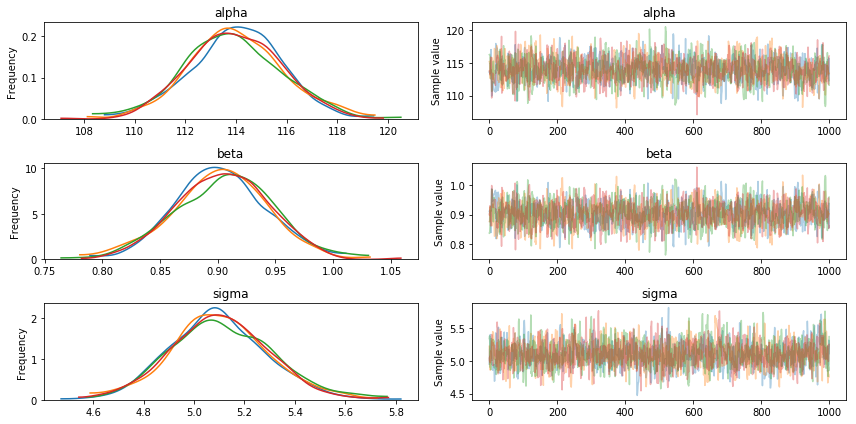

In [5]:
pm.traceplot(trace)

In [6]:
pm.summary(trace, alpha=0.11)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,113.946687,1.849704,0.046366,111.092803,117.034387,1584.0,1.000609
beta,0.903482,0.040745,0.001025,0.839232,0.969558,1574.0,1.000634
sigma,5.103650,0.196151,0.004884,4.793067,5.419200,1285.0,1.000584


In [7]:
weights = np.array([46.95, 43.72, 64.78, 32.59, 54.63])
for w in weights:
    mu_pred = trace['alpha'] + trace['beta'] * w
    mu_hpd = pm.hpd(mu_pred.T, alpha=.11)
    print('Weight = ' + str(w) + 
          ', Height = ' + str(np.mean(mu_pred)) + 
          ', HPD = ' + str(mu_hpd))

Weight = 46.95, Height = 156.365164457, HPD = [ 155.91168895  156.79637424]
Weight = 43.72, Height = 153.446917792, HPD = [ 153.01780314  153.88037939]
Weight = 64.78, Height = 172.47424744, HPD = [ 171.12442228  173.83178955]
Weight = 32.59, Height = 143.391163804, HPD = [ 142.578085    144.42103638]
Weight = 54.63, Height = 163.303905753, HPD = [ 162.50675121  164.03700825]


**4H2** Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right, you should end up wirh a new data frame with 192 rows in it.

In [8]:
observed_data = pd.read_csv('data/Howell1.csv', sep=';')
observed_data = observed_data[observed_data.age < 18]
print(observed_data.shape)

(192, 4)


a) Fit a linear regression to the data, using map. Present and interpret the estimates. For every 10 units of increase in weight, how much taller does the model predict a child gets?

In [9]:
basic_model = pm.Model()

with basic_model:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * observed_data.weight

    # likelihood of observations
    height = pm.Normal('height', mu=mu, sd=sigma, observed=observed_data.height)
    
    # Fit the model
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_interval__, beta, alpha]
100%|██████████| 1500/1500 [00:02<00:00, 641.18it/s]
The acceptance probability does not match the target. It is 0.879165769685, but should be close to 0.8. Try to increase the number of tuning steps.


In [10]:
pm.summary(trace, alpha=0.11)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,58.219625,1.400821,0.034821,55.974381,60.443533,1487.0,1.001307
beta,2.720973,0.069438,0.001780,2.609435,2.830223,1474.0,1.001201
sigma,8.533859,0.450376,0.008657,7.827908,9.261849,2418.0,0.999936


The mean height when weight is zero is 58.2cm. For each kilo increase, the height increases in 2.71cm. That means that each 10 kilos increase in weight corresponds to appox. 27.1cm increase in height. 

b) Plot the raw data with height on the vertical axis and weight on the horizontal axes. Superimpose the MAP regression line and 89% HDPI for the mean. Also superimpose 89% for the predicted heights.

In [11]:
weight_seq = np.linspace(start=observed_data.weight.min(), stop=observed_data.weight.max(), num=100)
# Mean and mean's HDPI calculation
mu_mean = []
mu_mean_hpd_l = []
mu_mean_hpd_h = []
for w in weight_seq:
    mu_pred = trace['alpha'] + trace['beta'] * w
    mu_mean.append(np.mean(mu_pred))
    mu_hpd = pm.hpd(mu_pred.T, alpha=.11)
    mu_mean_hpd_l.append(mu_hpd[0])
    mu_mean_hpd_h.append(mu_hpd[1])
# Predicted heights' HDPI
# We incorporate the uncertainty about sigma
height_hpd_l = []
height_hpd_h = []
weights = np.sort(observed_data.weight.values)
for w in weights:
    height_pred = np.random.normal(np.mean(trace['alpha'] + trace['beta'] * w), trace['sigma'])
    height_hpd = pm.hpd(height_pred.T, alpha=.11)
    height_hpd_l.append(height_hpd[0])
    height_hpd_h.append(height_hpd[1])

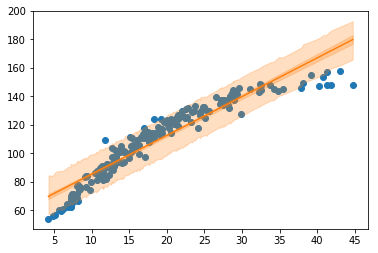

In [12]:
fig, ax = plt.subplots()
plt.scatter(observed_data.weight, observed_data.height)
plt.plot(weight_seq, mu_mean, color='C1')
plt.fill_between(weight_seq, mu_mean_hpd_l, mu_mean_hpd_h, color='C1', alpha=0.25)
plt.fill_between(weights, height_hpd_l, height_hpd_h, color='C1', alpha=0.25)

c) What aspects of the model fit concern you? Describe the kind of assumptions that you will change, if any, to improve the model. You don't have to write any new code. Just explain what the model appears to be doing a bad job of, and what you hypothesize would be a better model.

The relationship between weight and height does not seem to be linear. The fitted model approximates well the central part of the data, but the rate of height increase for heavier children seem to be lower, corresponding probably to a lower growing speed for older children. We should use a non-linear model to build this model. It seems that the relationship between height and weight is linear.

**4H3** Suppose a colleague of yours, who works on allometry, glances at the practice problems just above. Your colleague exclaims: "That's silly. Everyone knows that it's only the logarithm of body weight that scales with height!" Let's take your colleague advice and see what happens.

(a) Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Fit this model, using quadratic approximation:

```
hi ∼ Normal(μi, σ) 
μi =α+βlog(wi)
α ∼ Normal(178, 100) 
β ∼ Normal(0, 100)
σ ∼ Uniform(0, 50)
```

where hi is the height of individual i and wi is the weight (in kg) of individual i. The function for computing a natural log in R is just log. Can you interpret the resulting estimates?

In [13]:
# Load the data
observed_data = pd.read_csv('data/Howell1.csv', sep=';')

# Define the model
basic_model = pm.Model()

with basic_model:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * pm.math.log(observed_data.weight)

    # likelihood of observations
    height = pm.Normal('height', mu=mu, sd=sigma, observed=observed_data.height)

    # Fit the model 
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_interval__, beta, alpha]
100%|██████████| 2000/2000 [00:06<00:00, 316.10it/s]


In [14]:
pm.summary(trace, alpha=0.11)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,-23.644964,1.312481,0.036164,-25.633415,-21.471279,1477.0,1.000597
beta,47.036100,0.375717,0.010361,46.430934,47.618205,1491.0,1.000533
sigma,5.152418,0.154928,0.003421,4.915459,5.410704,1816.0,1.000410


b) Begin with this plot:

```
 plot( height ~ weight , data=Howell1 ,
    col=col.alpha(rangi2,0.4) )
```
Then use samples from the quadratic approximate posterior of the model in (a) to superimpose on the plot: (1) the predicted mean height as a function of weight, (2) the 97% HPDI for the mean, and (3) the 97% HPDI for predicted heights.

In [15]:
from math import log

weight_seq = np.linspace(start=observed_data.weight.min(), stop=observed_data.weight.max(), num=100)
# Mean and mean's HDPI calculation
mu_mean = []
mu_mean_hpd_l = []
mu_mean_hpd_h = []
for w in weight_seq:
    mu_pred = trace['alpha'] + trace['beta'] * log(w)
    mu_mean.append(np.mean(mu_pred))
    mu_hpd = pm.hpd(mu_pred.T, alpha=.03)
    mu_mean_hpd_l.append(mu_hpd[0])
    mu_mean_hpd_h.append(mu_hpd[1])
# Predicted heights' HDPI
# We incorporate the uncertainty about sigma
height_hpd_l = []
height_hpd_h = []
weights = np.sort(observed_data.weight.values)
for w in weights:
    height_pred = np.random.normal(np.mean(trace['alpha'] + trace['beta'] * log(w)), trace['sigma'])
    height_hpd = pm.hpd(height_pred.T, alpha=.03)
    height_hpd_l.append(height_hpd[0])
    height_hpd_h.append(height_hpd[1])

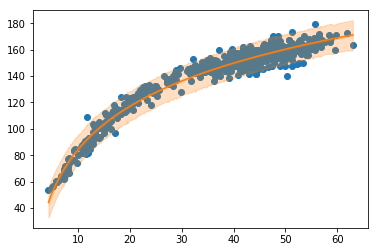

In [16]:
fig, ax = plt.subplots()
plt.scatter(observed_data.weight, observed_data.height)
plt.plot(weight_seq, mu_mean, color='C1')
plt.fill_between(weight_seq, mu_mean_hpd_l, mu_mean_hpd_h, color='C1', alpha=0.25)
plt.fill_between(weights, height_hpd_l, height_hpd_h, color='C1', alpha=0.25)